In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
###### check two data set
import os, sys
sys.path.append("/home/n/nguyenpk/CS6220/otdd")
import otdd
from otdd.pytorch.distance import DatasetDistance
#------------------------------------------------------
# pytorch library

import pandas as pd
import math
import random
import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch.nn.utils.rnn import pad_sequence
import pickle, pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn

import numpy as np
import torch.nn.functional as f

# -------------------------------------------
from transformers import BertModel, BertTokenizer,BertTokenizerFast
import gc
#--------------------------------------------------------
seed = 100
if torch.cuda.is_available():
    generator = torch.Generator('cuda').manual_seed(seed)
    device = "cuda:0"
else:
    generator = torch.Generator().manual_seed(seed)
    device = "cpu"

/home/n/nguyenpk/CS6220/otdd/otdd/pytorch/distance.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



[KeOps] Warning : There were warnings or errors compiling formula :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/home/n/nguyenpk/.local/lib/python3.8/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:5:10: fatal error: nvrtc.h: No such file or directory
    5 | #include <nvrtc.h>
      |          ^~~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc binder for pytho

2023-04-19 20:54:05.421727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
ot.gpu not found - coupling computation will be in cpu


# CREATE THE BERT TRANSFROM


In [3]:
# loading bert 
# -------------------------------------------
from transformers import BertModel, BertTokenizer,BertTokenizerFast
import gc
bert_version = 'bert-large-cased'
tokenizer = BertTokenizer.from_pretrained(bert_version)
model = BertModel.from_pretrained(bert_version)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
conf = {}
conf["pickle_raw_MELD"] = "/home/n/nguyenpk/CS6220/project/NLP_DS_distance/data/MELD_raw.pkl"
conf["pickle_raw_IEMOCAP"] = "/home/n/nguyenpk/CS6220/project/NLP_DS_distance/data/IEMOCAP_raw.pkl"
conf["pickle_raw_Daily"] = "/home/n/nguyenpk/CS6220/project/NLP_DS_distance/data/Daily_Dailog_raw.pkl"

In [4]:
dict_DS = {} ## --> data_name -> {'all', 'train', 'test', 'dev'}
rs = {}
# Read data from file and process
for ikey in ["IEMOCAP", "Daily", "MELD"]:
    print(ikey)
    idata = pd.read_pickle("data/BERT_embed/{}_bert_embd.pickle".format(ikey))
    data = torch.cat([i.to('cpu') for i in idata["embedd_CLS"]])
    label = torch.tensor(np.concatenate(idata["label"]), dtype = int)
    rs["{}_all".format(ikey)] = (data, label)
    # 
    n_train = len(idata["train"])
    n_test = len(idata["test"])
    n_dev = len(idata["valid"])
    # ----
    data_train = torch.cat([i.to('cpu') for i in idata["embedd_CLS"][:n_train]])
    label_train = torch.tensor(np.concatenate(idata["label"][:n_train]), dtype = int)
    rs["{}_train".format(ikey)] = (data_train, label_train)
    # --- 
    data_test = torch.cat([i.to('cpu') for i in idata["embedd_CLS"][n_train:n_train+n_test]])
    label_test = torch.tensor(np.concatenate(idata["label"][n_train:n_train+n_test]), dtype = int)
    rs["{}_test".format(ikey)] = (data_test, label_test)
    #
    data_dev = torch.cat([i.to('cpu') for i in idata["embedd_CLS"][n_train+n_test:]])
    label_dev = torch.tensor(np.concatenate(idata["label"][n_train+n_test:]), dtype=int)
    rs["{}_dev".format(ikey)] = (data_dev, label_dev)
    # del idata
    # gc.collect()
    # torch.cuda.empty_cache()


IEMOCAP
Daily
MELD


In [5]:
class my_DataSet(Dataset):
    """
     This class create my dataset
    """
    def __init__(self, data):
        self.data = data[0]
        self.targets = torch.tensor(data[1], dtype=int)
        self.len = len(self.targets)
    def __getitem__(self, index):
        return self.data[index], self.targets[index]
    def __len__(self):
        return self.len
    def __delitem__(self, key):
        self.data = np.delete(self.data, key, axis=0)
        self.targets = np.delete(self.targets, key, axis=0)
        
import os
os.environ['CUDA_PATH'] = '/usr/local/cuda-11'
print("Create the dataset")
dict_myDS = {}
for i in rs.keys():
    dict_myDS[i] = my_DataSet(rs[i])
    print(i, len(dict_myDS[i]), dict_myDS[i].data.shape, dict_myDS[i].targets.shape)

In [7]:
import os
os.environ['CUDA_PATH'] = '/usr/local/cuda-11'
print("Create the dataset")
dict_myDS = {}
for i in rs.keys():
    dict_myDS[i] = my_DataSet(rs[i])
    print(i, len(dict_myDS[i]), dict_myDS[i].data.shape, dict_myDS[i].targets.shape)

print("Begin compute the distance")
mapping_dict = dict(zip(range(len(dict_myDS)), list(dict_myDS.keys())))
m_matrix = np.zeros([len(mapping_dict), len(mapping_dict)])
for i in mapping_dict.keys():
    for j in mapping_dict.keys():
        print("Begin compute distance between:", mapping_dict[i], mapping_dict[j])
        D_i = dict_myDS[mapping_dict[i]]
        D_j = dict_myDS[mapping_dict[j]]
        dist = DatasetDistance(D_i, D_j,
                                   inner_ot_method = 'gaussian_approx',#gaussian_approx
                                   debiased_loss = True,
                                   p = 2, entreg = 1e-1,
                                   min_labelcount=1,
                                   device='cuda:0') ## error device!!
        
        d = dist.distance(maxsamples = 1000)
        m_matrix[i,j]  = d.item()
        print("Finish compute distance:", m_matrix[i,j])
print("Begin to saving")

distance = pd.DataFrame(m_matrix, columns=mapping_dict.values(), index=mapping_dict.values())
rs_glove_embedding_OTDD = {'df': distance, 'idx': mapping_dict, 'matrix':m_matrix}
pd.to_pickle(rs_glove_embedding_OTDD, "data/result/rs_BERT_CLR_OTDD.pkl")

Create the dataset
IEMOCAP_all 7433 torch.Size([7433, 1024]) torch.Size([7433])
IEMOCAP_train 5146 torch.Size([5146, 1024]) torch.Size([5146])
IEMOCAP_test 1623 torch.Size([1623, 1024]) torch.Size([1623])
IEMOCAP_dev 664 torch.Size([664, 1024]) torch.Size([664])
Daily_all 102979 torch.Size([102980, 1024]) torch.Size([102979])
Daily_train 87170 torch.Size([87171, 1024]) torch.Size([87170])
Daily_test 7740 torch.Size([7740, 1024]) torch.Size([7740])
Daily_dev 8069 torch.Size([8069, 1024]) torch.Size([8069])
MELD_all 13708 torch.Size([13708, 1024]) torch.Size([13708])
MELD_train 9989 torch.Size([9989, 1024]) torch.Size([9989])
MELD_test 2610 torch.Size([2610, 1024]) torch.Size([2610])
MELD_dev 1109 torch.Size([1109, 1024]) torch.Size([1109])
Begin compute the distance
Begin compute distance between: IEMOCAP_all IEMOCAP_all


/tmp/ipykernel_2532377/2001181946.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(data[1], dtype=int)


Finish compute distance: 31.560970306396484
Begin compute distance between: IEMOCAP_all IEMOCAP_train


Finish compute distance: 31.21151351928711
Begin compute distance between: IEMOCAP_all IEMOCAP_test


Finish compute distance: 32.854225158691406
Begin compute distance between: IEMOCAP_all IEMOCAP_dev


Finish compute distance: 37.97418975830078
Begin compute distance between: IEMOCAP_all Daily_all


Finish compute distance: 45.60504913330078
Begin compute distance between: IEMOCAP_all Daily_train


Finish compute distance: 45.76068878173828
Begin compute distance between: IEMOCAP_all Daily_test


Finish compute distance: 47.170562744140625
Begin compute distance between: IEMOCAP_all Daily_dev


Finish compute distance: 48.5601806640625
Begin compute distance between: IEMOCAP_all MELD_all


Finish compute distance: 52.20356750488281
Begin compute distance between: IEMOCAP_all MELD_train


Finish compute distance: 51.44481658935547
Begin compute distance between: IEMOCAP_all MELD_test


Finish compute distance: 54.0484619140625
Begin compute distance between: IEMOCAP_all MELD_dev


Finish compute distance: 56.25125503540039
Begin compute distance between: IEMOCAP_train IEMOCAP_all


Finish compute distance: 30.97854995727539
Begin compute distance between: IEMOCAP_train IEMOCAP_train


Finish compute distance: 28.87114715576172
Begin compute distance between: IEMOCAP_train IEMOCAP_test


Finish compute distance: 38.9508171081543
Begin compute distance between: IEMOCAP_train IEMOCAP_dev


Finish compute distance: 41.74617004394531
Begin compute distance between: IEMOCAP_train Daily_all


Finish compute distance: 45.2449951171875
Begin compute distance between: IEMOCAP_train Daily_train


Finish compute distance: 45.65160369873047
Begin compute distance between: IEMOCAP_train Daily_test


Finish compute distance: 46.413185119628906
Begin compute distance between: IEMOCAP_train Daily_dev


Finish compute distance: 49.261802673339844
Begin compute distance between: IEMOCAP_train MELD_all


Finish compute distance: 52.832122802734375
Begin compute distance between: IEMOCAP_train MELD_train


Finish compute distance: 51.86793518066406
Begin compute distance between: IEMOCAP_train MELD_test


Finish compute distance: 53.85216522216797
Begin compute distance between: IEMOCAP_train MELD_dev


Finish compute distance: 56.059513092041016
Begin compute distance between: IEMOCAP_test IEMOCAP_all


Finish compute distance: 32.684059143066406
Begin compute distance between: IEMOCAP_test IEMOCAP_train


Finish compute distance: 38.751068115234375
Begin compute distance between: IEMOCAP_test IEMOCAP_test


Finish compute distance: 16.54308319091797
Begin compute distance between: IEMOCAP_test IEMOCAP_dev


Finish compute distance: 43.452754974365234
Begin compute distance between: IEMOCAP_test Daily_all


Finish compute distance: 48.97753143310547
Begin compute distance between: IEMOCAP_test Daily_train


Finish compute distance: 48.42315673828125
Begin compute distance between: IEMOCAP_test Daily_test


Finish compute distance: 49.153663635253906
Begin compute distance between: IEMOCAP_test Daily_dev


Finish compute distance: 51.51222229003906
Begin compute distance between: IEMOCAP_test MELD_all


Finish compute distance: 53.73985290527344
Begin compute distance between: IEMOCAP_test MELD_train


Finish compute distance: 54.286399841308594
Begin compute distance between: IEMOCAP_test MELD_test


Finish compute distance: 55.63667678833008
Begin compute distance between: IEMOCAP_test MELD_dev


Finish compute distance: 57.16675567626953
Begin compute distance between: IEMOCAP_dev IEMOCAP_all


Finish compute distance: 37.27347183227539
Begin compute distance between: IEMOCAP_dev IEMOCAP_train


Finish compute distance: 41.711551666259766
Begin compute distance between: IEMOCAP_dev IEMOCAP_test


Finish compute distance: 43.071388244628906
Begin compute distance between: IEMOCAP_dev IEMOCAP_dev


Finish compute distance: 1.558901309967041
Begin compute distance between: IEMOCAP_dev Daily_all


Finish compute distance: 49.83213806152344
Begin compute distance between: IEMOCAP_dev Daily_train


Finish compute distance: 48.97060775756836
Begin compute distance between: IEMOCAP_dev Daily_test


Finish compute distance: 49.21058654785156
Begin compute distance between: IEMOCAP_dev Daily_dev


Finish compute distance: 49.95809555053711
Begin compute distance between: IEMOCAP_dev MELD_all


Finish compute distance: 56.96427917480469
Begin compute distance between: IEMOCAP_dev MELD_train


Finish compute distance: 55.22412872314453
Begin compute distance between: IEMOCAP_dev MELD_test


Finish compute distance: 57.711029052734375
Begin compute distance between: IEMOCAP_dev MELD_dev


Finish compute distance: 59.67267608642578
Begin compute distance between: Daily_all IEMOCAP_all


Finish compute distance: 46.62134552001953
Begin compute distance between: Daily_all IEMOCAP_train


Finish compute distance: 46.31105041503906
Begin compute distance between: Daily_all IEMOCAP_test


Finish compute distance: 48.547607421875
Begin compute distance between: Daily_all IEMOCAP_dev


Finish compute distance: 49.48705291748047
Begin compute distance between: Daily_all Daily_all


Finish compute distance: 33.35028076171875
Begin compute distance between: Daily_all Daily_train


Finish compute distance: 33.2509765625
Begin compute distance between: Daily_all Daily_test


Finish compute distance: 33.85511779785156
Begin compute distance between: Daily_all Daily_dev


Finish compute distance: 34.82617950439453
Begin compute distance between: Daily_all MELD_all


Finish compute distance: 52.307369232177734
Begin compute distance between: Daily_all MELD_train


Finish compute distance: 51.875579833984375
Begin compute distance between: Daily_all MELD_test


Finish compute distance: 52.50695037841797
Begin compute distance between: Daily_all MELD_dev


Finish compute distance: 56.89904022216797
Begin compute distance between: Daily_train IEMOCAP_all


Finish compute distance: 46.070648193359375
Begin compute distance between: Daily_train IEMOCAP_train


Finish compute distance: 45.55585479736328
Begin compute distance between: Daily_train IEMOCAP_test


Finish compute distance: 48.552207946777344
Begin compute distance between: Daily_train IEMOCAP_dev


Finish compute distance: 49.31855773925781
Begin compute distance between: Daily_train Daily_all


Finish compute distance: 34.121280670166016
Begin compute distance between: Daily_train Daily_train


Finish compute distance: 33.15802001953125
Begin compute distance between: Daily_train Daily_test


Finish compute distance: 34.36726379394531
Begin compute distance between: Daily_train Daily_dev


Finish compute distance: 34.75186538696289
Begin compute distance between: Daily_train MELD_all


Finish compute distance: 51.70064163208008
Begin compute distance between: Daily_train MELD_train


Finish compute distance: 52.427215576171875
Begin compute distance between: Daily_train MELD_test


Finish compute distance: 52.600521087646484
Begin compute distance between: Daily_train MELD_dev


Finish compute distance: 56.48667907714844
Begin compute distance between: Daily_test IEMOCAP_all


Finish compute distance: 46.093223571777344
Begin compute distance between: Daily_test IEMOCAP_train


Finish compute distance: 46.19845199584961
Begin compute distance between: Daily_test IEMOCAP_test


Finish compute distance: 48.626190185546875
Begin compute distance between: Daily_test IEMOCAP_dev


Finish compute distance: 48.87317657470703
Begin compute distance between: Daily_test Daily_all


Finish compute distance: 33.64174270629883
Begin compute distance between: Daily_test Daily_train


Finish compute distance: 33.81709289550781
Begin compute distance between: Daily_test Daily_test


Finish compute distance: 29.94483184814453
Begin compute distance between: Daily_test Daily_dev


Finish compute distance: 35.22023010253906
Begin compute distance between: Daily_test MELD_all


Finish compute distance: 54.36375045776367
Begin compute distance between: Daily_test MELD_train


Finish compute distance: 51.742000579833984
Begin compute distance between: Daily_test MELD_test


Finish compute distance: 53.1811408996582
Begin compute distance between: Daily_test MELD_dev


Finish compute distance: 56.888824462890625
Begin compute distance between: Daily_dev IEMOCAP_all


Finish compute distance: 48.97254180908203
Begin compute distance between: Daily_dev IEMOCAP_train


Finish compute distance: 46.89232635498047
Begin compute distance between: Daily_dev IEMOCAP_test


Finish compute distance: 49.80829620361328
Begin compute distance between: Daily_dev IEMOCAP_dev


Finish compute distance: 52.96632385253906
Begin compute distance between: Daily_dev Daily_all


Finish compute distance: 36.65452194213867
Begin compute distance between: Daily_dev Daily_train


Finish compute distance: 35.07366943359375
Begin compute distance between: Daily_dev Daily_test


Finish compute distance: 35.55860900878906
Begin compute distance between: Daily_dev Daily_dev


Finish compute distance: 28.5572509765625
Begin compute distance between: Daily_dev MELD_all


Finish compute distance: 53.19495391845703
Begin compute distance between: Daily_dev MELD_train


Finish compute distance: 54.97886657714844
Begin compute distance between: Daily_dev MELD_test


Finish compute distance: 55.75644302368164
Begin compute distance between: Daily_dev MELD_dev


Finish compute distance: 58.513458251953125
Begin compute distance between: MELD_all IEMOCAP_all


Finish compute distance: 52.86962890625
Begin compute distance between: MELD_all IEMOCAP_train


Finish compute distance: 57.006534576416016
Begin compute distance between: MELD_all Daily_all


Finish compute distance: 52.095672607421875
Begin compute distance between: MELD_all Daily_train


Finish compute distance: 51.726722717285156
Begin compute distance between: MELD_all Daily_test


Finish compute distance: 51.74628448486328
Begin compute distance between: MELD_all Daily_dev


Finish compute distance: 55.97486114501953
Begin compute distance between: MELD_all MELD_all


Finish compute distance: 40.172340393066406
Begin compute distance between: MELD_all MELD_train


Finish compute distance: 40.61578369140625
Begin compute distance between: MELD_all MELD_test


Finish compute distance: 41.22657012939453
Begin compute distance between: MELD_all MELD_dev


Finish compute distance: 42.56620788574219
Begin compute distance between: MELD_train IEMOCAP_all


Finish compute distance: 52.9914665222168
Begin compute distance between: MELD_train IEMOCAP_train


Finish compute distance: 52.230430603027344
Begin compute distance between: MELD_train IEMOCAP_test


Finish compute distance: 53.34385299682617
Begin compute distance between: MELD_train IEMOCAP_dev


Finish compute distance: 56.240455627441406
Begin compute distance between: MELD_train Daily_all


Finish compute distance: 52.205047607421875
Begin compute distance between: MELD_train Daily_train


Finish compute distance: 51.20026397705078
Begin compute distance between: MELD_train Daily_test


Finish compute distance: 53.79077911376953
Begin compute distance between: MELD_train Daily_dev


Finish compute distance: 52.686580657958984
Begin compute distance between: MELD_train MELD_all


Finish compute distance: 39.98434829711914
Begin compute distance between: MELD_train MELD_train


Finish compute distance: 38.23660659790039
Begin compute distance between: MELD_train MELD_test


Finish compute distance: 43.89629364013672
Begin compute distance between: MELD_train MELD_dev


Finish compute distance: 46.02497863769531
Begin compute distance between: MELD_test IEMOCAP_all


Finish compute distance: 53.804752349853516
Begin compute distance between: MELD_test IEMOCAP_train


Finish compute distance: 53.80808639526367
Begin compute distance between: MELD_test IEMOCAP_test


Finish compute distance: 54.81432342529297
Begin compute distance between: MELD_test IEMOCAP_dev


Finish compute distance: 57.403411865234375
Begin compute distance between: MELD_test Daily_all


Finish compute distance: 54.170745849609375
Begin compute distance between: MELD_test Daily_train


Finish compute distance: 53.399391174316406
Begin compute distance between: MELD_test Daily_test


Finish compute distance: 53.94709777832031
Begin compute distance between: MELD_test Daily_dev


Finish compute distance: 55.100799560546875
Begin compute distance between: MELD_test MELD_all


Finish compute distance: 40.87516784667969
Begin compute distance between: MELD_test MELD_train


Finish compute distance: 43.46695327758789
Begin compute distance between: MELD_test MELD_test


Finish compute distance: 27.22702407836914
Begin compute distance between: MELD_test MELD_dev


Finish compute distance: 46.66853332519531
Begin compute distance between: MELD_dev IEMOCAP_all


Finish compute distance: 55.9109992980957
Begin compute distance between: MELD_dev IEMOCAP_train


Finish compute distance: 56.23020935058594
Begin compute distance between: MELD_dev IEMOCAP_test


Finish compute distance: 57.07434844970703
Begin compute distance between: MELD_dev IEMOCAP_dev


Finish compute distance: 59.83638000488281
Begin compute distance between: MELD_dev Daily_all


Finish compute distance: 56.494937896728516
Begin compute distance between: MELD_dev Daily_train


Finish compute distance: 56.801639556884766
Begin compute distance between: MELD_dev Daily_test


Finish compute distance: 57.44383239746094
Begin compute distance between: MELD_dev Daily_dev


Finish compute distance: 59.26673126220703
Begin compute distance between: MELD_dev MELD_all


Finish compute distance: 43.32087707519531
Begin compute distance between: MELD_dev MELD_train


Finish compute distance: 46.01183319091797
Begin compute distance between: MELD_dev MELD_test


Finish compute distance: 47.00133514404297
Begin compute distance between: MELD_dev MELD_dev


Finish compute distance: 8.586250305175781
Begin to saving


In [15]:
pd.to_pickle(rs_glove_embedding_OTDD, "data/result/rs_BERT_CLR_OTDD.pkl")
columns = [
    'IEMOCAP_train',
    'IEMOCAP_test',
    'IEMOCAP_dev',
    'IEMOCAP_all',
    'Daily_train',
    'Daily_test',
    'Daily_dev',
    'Daily_all',
    'MELD_train',
    'MELD_test',
    'MELD_dev',
    'MELD_all',
]
distance.loc[columns, columns]

,IEMOCAP_train,IEMOCAP_test,IEMOCAP_dev,IEMOCAP_all,Daily_train,Daily_test,Daily_dev,Daily_all,MELD_train,MELD_test,MELD_dev,MELD_all
IEMOCAP_train,28.871147,38.950817,41.746170,30.978550,45.651604,46.413185,49.261803,45.244995,51.867935,53.852165,56.059513,52.832123
IEMOCAP_test,38.751068,16.543083,43.452755,32.684059,48.423157,49.153664,51.512222,48.977531,54.286400,55.636677,57.166756,53.739853
IEMOCAP_dev,41.711552,43.071388,1.558901,37.273472,48.970608,49.210587,49.958096,49.832138,55.224129,57.711029,59.672676,56.964279
IEMOCAP_all,31.211514,32.854225,37.974190,31.560970,45.760689,47.170563,48.560181,45.605049,51.444817,54.048462,56.251255,52.203568
Daily_train,45.555855,48.552208,49.318558,46.070648,33.158020,34.367264,34.751865,34.121281,52.427216,52.600521,56.486679,51.700642
Daily_test,46.198452,48.626190,48.873177,46.093224,33.817093,29.944832,35.220230,33.641743,51.742001,53.181141,56.888824,54.363750
Daily_dev,46.892326,49.808296,52.966324,48.972542,35.073669,35.558609,28.557251,36.654522,54.978867,55.756443,58.513458,53.194954
Daily_all,46.311050,48.547607,49.487053,46.621346,33.250977,33.855118,34.826180,33.350281,51.875580,52.506950,56.899040,52.307369
MELD_train,52.230431,53.343853,56.240456,52.991467,51.200264,53.790779,52.686581,52.205048,38.236607,43.896294,46.024979,39.984348
MELD_test,53.808086,54.814323,57.403412,53.804752,53.399391,53.947098,55.100800,54.170746,43.466953,27.227024,46.668533,40.875168


In [14]:
distance.index

Index(['IEMOCAP_all', 'IEMOCAP_train', 'IEMOCAP_test', 'IEMOCAP_dev',
       'Daily_all', 'Daily_train', 'Daily_test', 'Daily_dev', 'MELD_all',
       'MELD_train', 'MELD_test', 'MELD_dev'],
      dtype='object')

## Create DD topics!
- Can move this part to another place later


In [18]:
from preprocessing import preprocessing_raw as pr
# from preprocessing import preprocessing_token as pt
#
import sys
from sysconf import  conf
import pandas as pd, numpy as np, pickle
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

In [4]:
daily_tool = pr.Daily_Dialog_preprocessing()
conv_path = os.path.join(conf["raw_Daily_Dailog_path"], "dialogues_text.txt")
emo_path = os.path.join(conf["raw_Daily_Dailog_path"], "dialogues_emotion.txt")
act_path = os.path.join(conf["raw_Daily_Dailog_path"], "dialogues_act.txt")
topic_path = os.path.join(conf["raw_Daily_Dailog_path"], "dialogues_topic.txt")
data_raw_DD_topic = daily_tool.reading_DD(conv_path, emo_path, act_path, topic_path)
############ --- create again to make sure all of the data is have same label


In [5]:
len(data_raw_DD_topic['actions'])

13118

In [16]:
### This one already create before
data_raw_DD_topic = pd.read_pickle("data/Daily_topic_raw.pkl")

In [17]:
from transformers import BertModel, BertTokenizer,BertTokenizerFast
import gc
bert_version = 'bert-large-cased'
tokenizer = BertTokenizer.from_pretrained(bert_version)
model = BertModel.from_pretrained(bert_version)
model = model.eval()
model = model.to(device)


data = data_raw_DD_topic
ll  = []
ll_label = []
ll_topic = []
ll_conv_len = []
icount = 0
ilen   = 0

for idx, conv in enumerate(data['conversation']):
    ll.append(conv)
    ll_label.append(data["emotions"][idx])
    ll_topic.append(data["topics"][idx])
    ll_conv_len.append(len(conv))

rs_embedd_CLS = []
rs_embedd_AVG = []
print(len(ll))
for ii, subtext in enumerate(ll):
    if (ii % 100) == 0:
        print(ii)
    encodings = tokenizer(
        subtext, # the texts to be tokenized
        padding="max_length", max_length=300,
        # padding=True, # pad the texts to the maximum length (so that all outputs have the same length)
        return_tensors='pt' # return the tensors (not lists)
    )
    encodings = encodings.to(device)
    with torch.no_grad():
        embeds = model(**encodings)
    rs_embedd_CLS.append(embeds[0][:, 0, :].to('cpu'))
    rs_embedd_AVG.append(embeds[0].mean(dim=1).to('cpu'))
    del embeds
    del encodings
    gc.collect()
    torch.cuda.empty_cache()

rs_out  = {'embedd_CLS': rs_embedd_CLS, 'embedd_AVG': rs_embedd_AVG, 'label':ll_label, 'topic':ll_topic , "len": ll_conv_len}
pd.to_pickle(rs_out, "data/Daily_topic_BERT.pkl")

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


13117
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100


In [6]:
from sklearn import preprocessing
class my_DataSet(Dataset):
    """
     This class create my dataset
    """
    def __init__(self, data):
        self.data = data[0]
        self.clf = preprocessing.LabelEncoder()
        self.targets = torch.tensor(self.clf.fit_transform(data[1]), dtype=int)
        self.y_raw = data[1] 
        self.len = len(self.targets)
    def __getitem__(self, index):
        return self.data[index], self.targets[index]
    def __len__(self):
        return self.len
    def __delitem__(self, key):
        self.data = np.delete(self.data, key, axis=0)
        self.targets = np.delete(self.targets, key, axis=0)

In [23]:
rs = pd.read_pickle("data/Daily_topic_BERT.pkl")
len(rs["embedd_CLS"])

13117

In [28]:
rs = pd.read_pickle("data/Daily_topic_BERT.pkl")
topic = pd.read_pickle("refix_topic_672.pickle")
topic_DS = {}
for i in sorted(np.unique(topic)):
    ll_x = []
    ll_y = []
    for index,j in enumerate(topic):
        if i ==j :
            data = rs['embedd_CLS'][index]
            label = rs['label'][index]
            ll_x.append(data)
            ll_y.append(label)
    X = torch.cat(ll_x)
    y = np.concatenate(ll_y)
    topic_DS[i] = my_DataSet((X,y))

In [29]:
mapping_dict = dict(zip(range(len(topic_DS)), list(topic_DS.keys())))
m_matrix = np.zeros([len(topic_DS.keys()), len(topic_DS.keys())])
for i in range(len(topic_DS.keys())):
    for j in range(len(topic_DS.keys())):
        print("Begin compute distance between:", i, j)
        D_i = topic_DS[mapping_dict[i]]
        D_j = topic_DS[mapping_dict[j]]
        try:
            dist = DatasetDistance(D_i, D_j,
                                       inner_ot_method = 'gaussian_approx',#gaussian_approx
                                       debiased_loss = True,
                                       p = 2, entreg = 1e-1,
                                       min_labelcount=1,
                                       device='cpu') ## error device!!

            d = dist.distance(maxsamples = 1000)
            m_matrix[i,j]  = d.item()
            print("Finish compute distance:", m_matrix[i,j])
        except:
            print(i, j, "Error but continue")
print("Begin to saving")

pd.to_pickle(m_matrix, "data/result/rs_bert_TOPIC_OTDD.pkl")

Begin compute distance between: 0 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 32.767276763916016
Begin compute distance between: 0 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 36.23933410644531
Begin compute distance between: 0 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 2 Error but continue
Begin compute distance between: 0 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 39.01768493652344
Begin compute distance between: 0 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 39.069576263427734
Begin compute distance between: 0 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 34.73722457885742
Begin compute distance between: 0 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 36.867149353027344
Begin compute distance between: 0 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 37.04832458496094
Begin compute distance between: 0 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 39.13059616088867
Begin compute distance between: 0 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 37.17080307006836
Begin compute distance between: 1 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 35.690860748291016
Begin compute distance between: 1 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 24.268489837646484
Begin compute distance between: 1 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

1 2 Error but continue
Begin compute distance between: 1 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 37.18196487426758
Begin compute distance between: 1 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 35.822410583496094
Begin compute distance between: 1 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 35.356101989746094
Begin compute distance between: 1 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 35.99144744873047
Begin compute distance between: 1 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 34.883087158203125
Begin compute distance between: 1 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 36.9434814453125
Begin compute distance between: 1 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 37.108402252197266
Begin compute distance between: 2 0


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2 0 Error but continue
Begin compute distance between: 2 1


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.
 -- Class '         1' has too few examples (1). Ignoring it.


2 1 Error but continue
Begin compute distance between: 2 2


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


2 2 Error but continue
Begin compute distance between: 2 3


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


2 3 Error but continue
Begin compute distance between: 2 4


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2 4 Error but continue
Begin compute distance between: 2 5


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


Finish compute distance: 46.62531280517578
Begin compute distance between: 2 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


2 6 Error but continue
Begin compute distance between: 2 7


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


2 7 Error but continue
Begin compute distance between: 2 8


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 48.02583312988281
Begin compute distance between: 2 9


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 62.4076042175293
Begin compute distance between: 3 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 37.54556655883789
Begin compute distance between: 3 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 37.842735290527344
Begin compute distance between: 3 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

3 2 Error but continue
Begin compute distance between: 3 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 26.704086303710938
Begin compute distance between: 3 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 38.71192169189453
Begin compute distance between: 3 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 41.27906799316406
Begin compute distance between: 3 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 40.315155029296875
Begin compute distance between: 3 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 39.73369598388672
Begin compute distance between: 3 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 40.17606735229492
Begin compute distance between: 3 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 41.91661071777344
Begin compute distance between: 4 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 38.947792053222656
Begin compute distance between: 4 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 38.01145935058594
Begin compute distance between: 4 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

4 2 Error but continue
Begin compute distance between: 4 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 38.41830062866211
Begin compute distance between: 4 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 33.37348556518555
Begin compute distance between: 4 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 38.62206268310547
Begin compute distance between: 4 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 38.54875946044922
Begin compute distance between: 4 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 37.79497146606445
Begin compute distance between: 4 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 39.31352996826172
Begin compute distance between: 4 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 42.7978515625
Begin compute distance between: 5 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 35.25238037109375
Begin compute distance between: 5 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 35.53795623779297
Begin compute distance between: 5 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

5 2 Error but continue
Begin compute distance between: 5 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 41.78038787841797
Begin compute distance between: 5 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 38.807212829589844
Begin compute distance between: 5 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 26.535425186157227
Begin compute distance between: 5 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

5 6 Error but continue
Begin compute distance between: 5 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 34.55780792236328
Begin compute distance between: 5 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 40.5661506652832
Begin compute distance between: 5 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 33.99771499633789
Begin compute distance between: 6 0


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6 0 Error but continue
Begin compute distance between: 6 1


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6 1 Error but continue
Begin compute distance between: 6 2


 -- Class '         2' has too few examples (1). Ignoring it.
 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

6 2 Error but continue
Begin compute distance between: 6 3


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6 3 Error but continue
Begin compute distance between: 6 4


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6 4 Error but continue
Begin compute distance between: 6 5


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 42.804222106933594
Begin compute distance between: 6 6


 -- Class '         2' has too few examples (1). Ignoring it.
 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6 6 Error but continue
Begin compute distance between: 6 7


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6 7 Error but continue
Begin compute distance between: 6 8


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6 8 Error but continue
Begin compute distance between: 6 9


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 57.048370361328125
Begin compute distance between: 7 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 37.57678985595703
Begin compute distance between: 7 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 34.13758087158203
Begin compute distance between: 7 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

7 2 Error but continue
Begin compute distance between: 7 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 39.74766159057617
Begin compute distance between: 7 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 37.6044921875
Begin compute distance between: 7 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 34.31359100341797
Begin compute distance between: 7 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 36.69503402709961
Begin compute distance between: 7 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 27.97614288330078
Begin compute distance between: 7 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 39.64821243286133
Begin compute distance between: 7 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 33.427711486816406
Begin compute distance between: 8 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 39.627525329589844
Begin compute distance between: 8 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 38.276268005371094
Begin compute distance between: 8 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

8 2 Error but continue
Begin compute distance between: 8 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 39.851959228515625
Begin compute distance between: 8 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 39.04882049560547
Begin compute distance between: 8 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 39.78541564941406
Begin compute distance between: 8 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 41.19830322265625
Begin compute distance between: 8 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 40.838233947753906
Begin compute distance between: 8 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 14.76856517791748
Begin compute distance between: 8 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 41.19217300415039
Begin compute distance between: 9 0


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 36.30517578125
Begin compute distance between: 9 1


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 37.215457916259766
Begin compute distance between: 9 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

9 2 Error but continue
Begin compute distance between: 9 3


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 41.14283752441406
Begin compute distance between: 9 4


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 40.18119812011719
Begin compute distance between: 9 5


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 33.67582702636719
Begin compute distance between: 9 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

9 6 Error but continue
Begin compute distance between: 9 7


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 33.896514892578125
Begin compute distance between: 9 8


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 42.02789306640625
Begin compute distance between: 9 9


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 23.11639976501465
Begin to saving


In [32]:
m_matrix

array([[32.76727676, 36.23933411,  0.        , 39.01768494, 39.06957626,
        34.73722458, 36.86714935, 37.04832458, 39.13059616, 37.17080307],
       [35.69086075, 24.26848984,  0.        , 37.18196487, 35.82241058,
        35.35610199, 35.99144745, 34.88308716, 36.94348145, 37.10840225],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        46.62531281,  0.        ,  0.        , 48.02583313, 62.40760422],
       [37.54556656, 37.84273529,  0.        , 26.7040863 , 38.71192169,
        41.27906799, 40.31515503, 39.73369598, 40.17606735, 41.91661072],
       [38.94779205, 38.01145935,  0.        , 38.41830063, 33.37348557,
        38.62206268, 38.54875946, 37.79497147, 39.31352997, 42.79785156],
       [35.25238037, 35.53795624,  0.        , 41.78038788, 38.80721283,
        26.53542519,  0.        , 34.55780792, 40.56615067, 33.997715  ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        42.80422211,  0.        ,  0.        

In [33]:
pd.DataFrame(m_matrix, index=mapping_dict.values(), columns= mapping_dict.values())

,1,2,3,4,5,6,7,8,9,10
1,32.767277,36.239334,0.0,39.017685,39.069576,34.737225,36.867149,37.048325,39.130596,37.170803
2,35.690861,24.268490,0.0,37.181965,35.822411,35.356102,35.991447,34.883087,36.943481,37.108402
3,0.000000,0.000000,0.0,0.000000,0.000000,46.625313,0.000000,0.000000,48.025833,62.407604
4,37.545567,37.842735,0.0,26.704086,38.711922,41.279068,40.315155,39.733696,40.176067,41.916611
5,38.947792,38.011459,0.0,38.418301,33.373486,38.622063,38.548759,37.794971,39.313530,42.797852
6,35.252380,35.537956,0.0,41.780388,38.807213,26.535425,0.000000,34.557808,40.566151,33.997715
7,0.000000,0.000000,0.0,0.000000,0.000000,42.804222,0.000000,0.000000,0.000000,57.048370
8,37.576790,34.137581,0.0,39.747662,37.604492,34.313591,36.695034,27.976143,39.648212,33.427711
9,39.627525,38.276268,0.0,39.851959,39.048820,39.785416,41.198303,40.838234,14.768565,41.192173
10,36.305176,37.215458,0.0,41.142838,40.181198,33.675827,0.000000,33.896515,42.027893,23.116400


1

In [14]:
rs = pd.read_pickle("data/Daily_topic_BERT.pkl")
topic_DS = {}
for i in sorted(np.unique(rs["topic"])):
    ll_x = []
    ll_y = []
    for j in rs["topic"]:
        if i == j:
            data = rs['embedd_AVG'][j]
            label = rs['label'][j]
            ll_x.append(data)
            ll_y.append(label)
    X = torch.cat(ll_x)
    y = np.concatenate(ll_y)
    topic_DS[i] = my_DataSet((X,y))
    
#-----
mapping_dict = dict(zip(range(len(topic_DS)), list(topic_DS.keys())))
m_matrix = np.zeros([len(topic_DS.keys()), len(topic_DS.keys())])
for i in range(len(topic_DS.keys())):
    for j in range(len(topic_DS.keys())):
        print("Begin compute distance between:", i, j)
        D_i = topic_DS[mapping_dict[i]]
        D_j = topic_DS[mapping_dict[j]]
        dist = DatasetDistance(D_i, D_j,
                                   inner_ot_method = 'gaussian_approx',#gaussian_approx
                                   debiased_loss = True,
                                   p = 2, entreg = 1e-1,
                                   min_labelcount=1,
                                   device='cpu') ## error device!!
        
        d = dist.distance(maxsamples = 1000)
        m_matrix[i,j]  = d.item()
        print("Finish compute distance:", m_matrix[i,j])
print("Begin to saving")

pd.to_pickle(m_matrix, "data/result/rs_bert_AVG_TOPIC_OTDD.pkl")

Begin compute distance between: 0 0


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.44152987003326416
Begin compute distance between: 0 1


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 86.43411254882812
Begin compute distance between: 0 2


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 94.8914794921875
Begin compute distance between: 0 3


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Finish compute distance: 84.95977783203125
Begin compute distance between: 1 0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

_LinAlgError: symeig_cpu: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated eigenvalues (error code: 1013).

In [ ]:
# pd.DataFrame(m_matrix, index=mapping_dict.values(), columns= mapping_dict.values())

In [28]:
# ################## --- using distance to predict the topics!!!
# rs = pd.read_pickle("data/Daily_topic_BERT.pkl")
# DD_DS = {}
# for i in range(len(rs['embedd_CLS'])):
#     if rs["len"][i] >= 12:
#         if rs["topic"][idx] == 4:
#             continue
#         idata = rs['embedd_CLS'][i]
#         ilabel = rs['label'][i]
#         DD_DS[i] = my_DataSet((idata, ilabel))
# pd.to_pickle(DD_DS, "my_DD_CLS_BERT.pickle")

In [29]:
4# len(DD_DS)

2535

In [34]:
#####
graph_bert_topic = pd.read_pickle("data/embedd_GAE_DD_TOPIC.pkl")

In [44]:
DS_topic = {}
for i in graph_bert_topic.keys():
    DS_topic[i] = my_DataSet((graph_bert_topic[i]['emb'], np.array(list(graph_bert_topic[i]['label'].values()))))

In [46]:
mapping_dict = dict(zip(range(len(DS_topic)), list(DS_topic.keys())))
m_matrix = np.zeros([len(DS_topic.keys()), len(DS_topic.keys())])
for i in range(len(DS_topic.keys())):
    for j in range(len(DS_topic.keys())):
        print("Begin compute distance between:", i, j)
        D_i = DS_topic[mapping_dict[i]]
        D_j = DS_topic[mapping_dict[j]]
        try:
            dist = DatasetDistance(D_i, D_j,
                                       inner_ot_method = 'gaussian_approx',#gaussian_approx
                                       debiased_loss = True,
                                       p = 2, entreg = 1e-1,
                                       min_labelcount=1,
                                       device='cpu') ## error device!!

            d = dist.distance(maxsamples = 100)
            m_matrix[i,j]  = d.item()
            print("Finish compute distance:", m_matrix[i,j])
        except:
            print(i, j, "Error but continue")
print("Begin to saving")

pd.to_pickle(m_matrix, "data/result/rs_bert_VGAE_TOPIC_OTDD.pkl")

Begin compute distance between: 0 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0027193366549909115
Begin compute distance between: 0 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.9055821895599365
Begin compute distance between: 0 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 2 Error but continue
Begin compute distance between: 0 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.0400081872940063
Begin compute distance between: 0 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.0296049118041992
Begin compute distance between: 0 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.3911501169204712
Begin compute distance between: 0 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.0458173751831055
Begin compute distance between: 0 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.820021629333496
Begin compute distance between: 0 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.0949463844299316
Begin compute distance between: 0 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.5281987190246582
Begin compute distance between: 1 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.8948359489440918
Begin compute distance between: 1 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 6.768286402802914e-05
Begin compute distance between: 1 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

1 2 Error but continue
Begin compute distance between: 1 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.9826006889343262
Begin compute distance between: 1 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.9771507978439331
Begin compute distance between: 1 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.7680792808532715
Begin compute distance between: 1 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.9797373414039612
Begin compute distance between: 1 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.7735328674316406
Begin compute distance between: 1 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.9748713970184326
Begin compute distance between: 1 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


Finish compute distance: 1.231013298034668
Begin compute distance between: 2 0


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


2 0 Error but continue
Begin compute distance between: 2 1


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.
 -- Class '         1' has too few examples (1). Ignoring it.


2 1 Error but continue
Begin compute distance between: 2 2


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


2 2 Error but continue
Begin compute distance between: 2 3


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


2 3 Error but continue
Begin compute distance between: 2 4


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


Finish compute distance: -5.383634871236609e-09
Begin compute distance between: 2 5


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


2 5 Error but continue
Begin compute distance between: 2 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


2 6 Error but continue
Begin compute distance between: 2 7


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


2 7 Error but continue
Begin compute distance between: 2 8


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         1' has too few examples (1). Ignoring it.


2 8 Error but continue
Begin compute distance between: 2 9


0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2 9 Error but continue
Begin compute distance between: 3 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.0725382566452026
Begin compute distance between: 3 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.9867475628852844
Begin compute distance between: 3 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

3 2 Error but continue
Begin compute distance between: 3 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0
Begin compute distance between: 3 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 3.0562929168809205e-05
Begin compute distance between: 3 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.576129674911499
Begin compute distance between: 3 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0
Begin compute distance between: 3 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.7156105041503906
Begin compute distance between: 3 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0
Begin compute distance between: 3 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.3631785213947296
Begin compute distance between: 4 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.0144438743591309
Begin compute distance between: 4 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.9735100865364075
Begin compute distance between: 4 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

4 2 Error but continue
Begin compute distance between: 4 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 3.2285694032907486e-05
Begin compute distance between: 4 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.000927341010538e-09
Begin compute distance between: 4 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.5788245797157288
Begin compute distance between: 4 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 3.0250554118538275e-05
Begin compute distance between: 4 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.6848413944244385
Begin compute distance between: 4 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 3.0772782338317484e-05
Begin compute distance between: 4 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.36484289169311523
Begin compute distance between: 5 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.3681468963623047
Begin compute distance between: 5 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.7666457891464233
Begin compute distance between: 5 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

5 2 Error but continue
Begin compute distance between: 5 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.5765393972396851
Begin compute distance between: 5 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.5707318782806396
Begin compute distance between: 5 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.071716906153597e-05
Begin compute distance between: 5 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.5742628574371338
Begin compute distance between: 5 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.176896095275879
Begin compute distance between: 5 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.573170006275177
Begin compute distance between: 5 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.40071439743042
Begin compute distance between: 6 0


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6 0 Error but continue
Begin compute distance between: 6 1


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6 1 Error but continue
Begin compute distance between: 6 2


 -- Class '         2' has too few examples (1). Ignoring it.
 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

6 2 Error but continue
Begin compute distance between: 6 3


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6 3 Error but continue
Begin compute distance between: 6 4


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6 4 Error but continue
Begin compute distance between: 6 5


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         2' has too few examples (1). Ignoring it.


Finish compute distance: 0.57790607213974
Begin compute distance between: 6 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6 6 Error but continue
Begin compute distance between: 6 7


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 -- Class '         2' has too few examples (1). Ignoring it.


Finish compute distance: 1.7795088291168213
Begin compute distance between: 6 8


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6 8 Error but continue
Begin compute distance between: 6 9


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.3435876965522766
Begin compute distance between: 7 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.7249860763549805
Begin compute distance between: 7 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.7270407676696777
Begin compute distance between: 7 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

7 2 Error but continue
Begin compute distance between: 7 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.7056739330291748
Begin compute distance between: 7 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.6928935050964355
Begin compute distance between: 7 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.16617488861084
Begin compute distance between: 7 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.700973629951477
Begin compute distance between: 7 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0028681233525276184
Begin compute distance between: 7 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.690464973449707
Begin compute distance between: 7 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.2243452072143555
Begin compute distance between: 8 0


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.0316849946975708
Begin compute distance between: 8 1


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.9823330044746399
Begin compute distance between: 8 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

8 2 Error but continue
Begin compute distance between: 8 3


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0
Begin compute distance between: 8 4


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.9770473702228628e-05
Begin compute distance between: 8 5


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.5760246515274048
Begin compute distance between: 8 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0
Begin compute distance between: 8 7


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.714993953704834
Begin compute distance between: 8 8


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0
Begin compute distance between: 8 9


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.3651188611984253
Begin compute distance between: 9 0


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.5558199882507324
Begin compute distance between: 9 1


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.232114315032959
Begin compute distance between: 9 2


 -- Class '         1' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

9 2 Error but continue
Begin compute distance between: 9 3


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.36530372500419617
Begin compute distance between: 9 4


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.3653552532196045
Begin compute distance between: 9 5


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.402480959892273
Begin compute distance between: 9 6


 -- Class '         2' has too few examples (1). Ignoring it.


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

9 6 Error but continue
Begin compute distance between: 9 7


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.2314505577087402
Begin compute distance between: 9 8


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.36279404163360596
Begin compute distance between: 9 9


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 5.254620191408321e-05
Begin to saving


In [47]:
pd.DataFrame(m_matrix, index=mapping_dict.values(), columns= mapping_dict.values())

,0,1,2,3,4,5,6,7,8,9
0,0.002719,1.905582,0.0,1.040008,1.029605e+00,1.391150,1.045817,2.820022,1.094946,1.528199
1,1.894836,0.000068,0.0,0.982601,9.771508e-01,1.768079,0.979737,2.773533,0.974871,1.231013
2,0.000000,0.000000,0.0,0.000000,-5.383635e-09,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.072538,0.986748,0.0,0.000000,3.056293e-05,0.576130,0.000000,1.715611,0.000000,0.363179
4,1.014444,0.973510,0.0,0.000032,1.000927e-09,0.578825,0.000030,1.684841,0.000031,0.364843
5,1.368147,1.766646,0.0,0.576539,5.707319e-01,0.000011,0.574263,2.176896,0.573170,1.400714
6,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.577906,0.000000,1.779509,0.000000,0.343588
7,2.724986,2.727041,0.0,1.705674,1.692894e+00,2.166175,1.700974,0.002868,1.690465,2.224345
8,1.031685,0.982333,0.0,0.000000,2.977047e-05,0.576025,0.000000,1.714994,0.000000,0.365119
9,1.555820,1.232114,0.0,0.365304,3.653553e-01,1.402481,0.000000,2.231451,0.362794,0.000053


In [48]:
import seaborn as sns

In [59]:
bert_distance = pd.read_pickle("data/result/rs_BERT_CLR_OTDD.pkl")
columns = [
    'IEMOCAP_train',
    'IEMOCAP_test',
    'IEMOCAP_dev',
    'IEMOCAP_all',
    'Daily_train',
    'Daily_test',
    'Daily_dev',
    'Daily_all',
    'MELD_train',
    'MELD_test',
    'MELD_dev',
    'MELD_all',
]
bert_distance['df'].loc[columns, columns]

,IEMOCAP_train,IEMOCAP_test,IEMOCAP_dev,IEMOCAP_all,Daily_train,Daily_test,Daily_dev,Daily_all,MELD_train,MELD_test,MELD_dev,MELD_all
IEMOCAP_train,28.871147,38.950817,41.746170,30.978550,45.651604,46.413185,49.261803,45.244995,51.867935,53.852165,56.059513,52.832123
IEMOCAP_test,38.751068,16.543083,43.452755,32.684059,48.423157,49.153664,51.512222,48.977531,54.286400,55.636677,57.166756,53.739853
IEMOCAP_dev,41.711552,43.071388,1.558901,37.273472,48.970608,49.210587,49.958096,49.832138,55.224129,57.711029,59.672676,56.964279
IEMOCAP_all,31.211514,32.854225,37.974190,31.560970,45.760689,47.170563,48.560181,45.605049,51.444817,54.048462,56.251255,52.203568
Daily_train,45.555855,48.552208,49.318558,46.070648,33.158020,34.367264,34.751865,34.121281,52.427216,52.600521,56.486679,51.700642
Daily_test,46.198452,48.626190,48.873177,46.093224,33.817093,29.944832,35.220230,33.641743,51.742001,53.181141,56.888824,54.363750
Daily_dev,46.892326,49.808296,52.966324,48.972542,35.073669,35.558609,28.557251,36.654522,54.978867,55.756443,58.513458,53.194954
Daily_all,46.311050,48.547607,49.487053,46.621346,33.250977,33.855118,34.826180,33.350281,51.875580,52.506950,56.899040,52.307369
MELD_train,52.230431,53.343853,56.240456,52.991467,51.200264,53.790779,52.686581,52.205048,38.236607,43.896294,46.024979,39.984348
MELD_test,53.808086,54.814323,57.403412,53.804752,53.399391,53.947098,55.100800,54.170746,43.466953,27.227024,46.668533,40.875168


In [72]:
bertavg_distance = pd.read_pickle("data/result/rs_BERT_AVG_OTDD.pkl")
columns = [
    'IEMOCAP_train',
    'IEMOCAP_test',
    'IEMOCAP_dev',
    'IEMOCAP_all',
    'Daily_train',
    'Daily_test',
    'Daily_dev',
    'Daily_all',
    'MELD_train',
    'MELD_test',
    'MELD_dev',
    'MELD_all',
]
bertavg_distance['df'].loc[columns, columns]

,IEMOCAP_train,IEMOCAP_test,IEMOCAP_dev,IEMOCAP_all,Daily_train,Daily_test,Daily_dev,Daily_all,MELD_train,MELD_test,MELD_dev,MELD_all
IEMOCAP_train,32.277931,40.894196,43.170723,34.578705,54.217453,54.420845,58.740479,53.878090,61.946701,61.858204,63.981796,61.437073
IEMOCAP_test,40.220375,18.538488,43.048248,35.083717,55.913681,55.968994,59.536686,55.004307,62.242676,62.931885,63.578438,61.528900
IEMOCAP_dev,43.122246,43.090126,3.673385,39.162689,56.453671,57.902344,58.500748,56.267296,63.867805,64.774277,65.754547,63.758999
IEMOCAP_all,33.692795,36.011444,39.022572,33.969486,54.167572,54.684887,58.195526,54.747955,61.561352,62.014416,63.264862,62.183739
Daily_train,54.300270,55.466175,56.647053,54.268005,42.534813,44.176659,42.784935,42.011292,65.266411,66.131081,68.201630,65.447067
Daily_test,54.330116,55.625061,56.332382,54.177826,42.523121,37.916553,44.842506,42.045059,65.567093,67.261559,68.077354,66.751656
Daily_dev,57.042412,58.498466,58.349152,57.948410,43.937019,44.172306,37.097050,43.600845,68.264328,70.233658,71.989319,70.141907
Daily_all,54.904907,55.554230,56.422752,53.318398,41.944279,42.006123,44.194302,41.991234,66.515442,66.659630,68.565681,65.783844
MELD_train,61.717556,62.172729,64.034050,61.035934,65.377357,66.718887,69.671066,65.789886,47.122158,50.958061,52.524208,47.738724
MELD_test,62.289677,62.348434,64.929245,62.445602,66.091202,65.997025,70.406258,67.231071,51.521027,34.979897,52.554962,48.662449


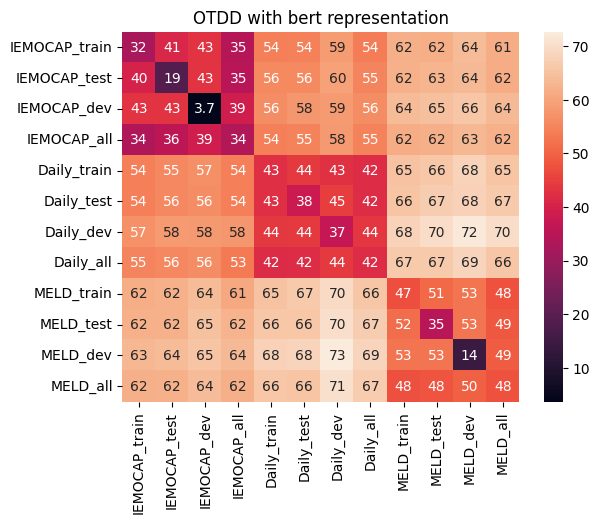

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = plt.axes()
sns.heatmap(bertavg_distance['df'].loc[columns, columns], annot=True, ax=ax)
ax.set_title('OTDD with bert representation')
plt.show()

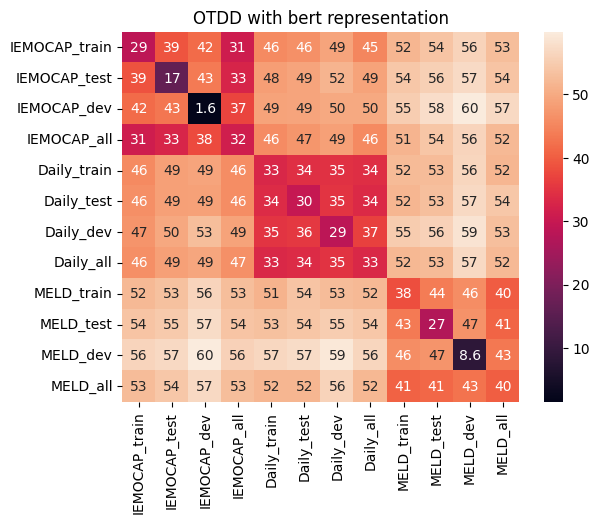

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = plt.axes()
sns.heatmap(bert_distance['df'].loc[columns, columns], annot=True, ax=ax)
ax.set_title('OTDD with bert representation')
plt.show()

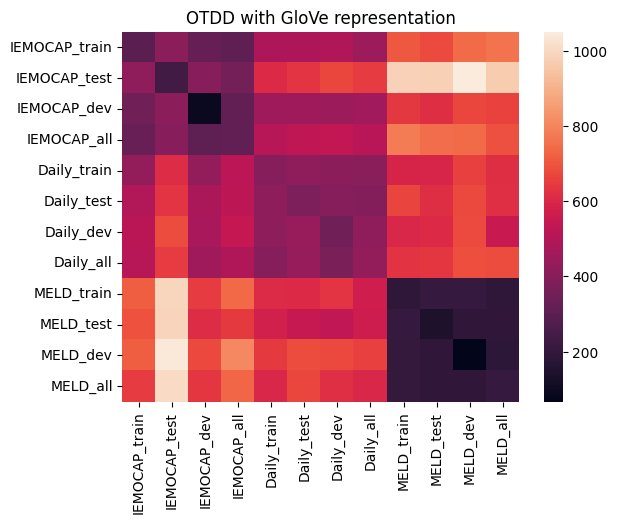

In [63]:
glove_distance = pd.read_pickle("data/result/rs_glove_embedding_OTDD.pkl")

ax = plt.axes()
sns.heatmap(glove_distance['df'].loc[columns, columns], annot=Tr, ax=ax)
ax.set_title('OTDD with GloVe representation')
plt.show()

In [64]:
WL_distance = pd.read_pickle("data/result/WL_distance.pkl")

In [66]:
WL_distance.columns

Index(['IEMOCAP_train', 'IEMOCAP_test', 'IEMOCAP_dev', 'IEMOCAP_all',
       'Daily_Dailog_train', 'Daily_Dailog_test', 'Daily_Dailog_dev',
       'Daily_Dailog_all', 'MELD_train', 'MELD_test', 'MELD_dev', 'MELD_all'],
      dtype='object')

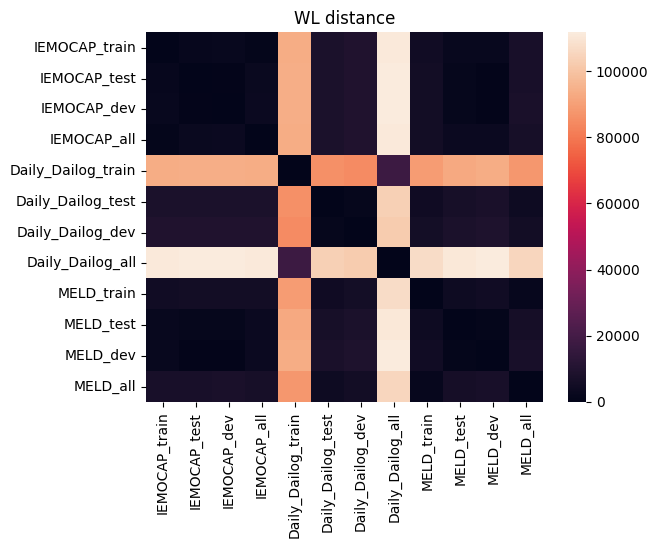

In [69]:
glove_distance = pd.read_pickle("data/result/rs_glove_embedding_OTDD.pkl")

ax = plt.axes()
sns.heatmap(WL_distance, annot=False, ax=ax)
ax.set_title('WL distance')
plt.show()

In [74]:
DD = pd.read_pickle("data/VGAE/DD_vgae.pickle")
IM = pd.read_pickle("data/VGAE/IEMOCAP_vgae.pickle")
MELD = pd.read_pickle("data/VGAE/MELD_vgae.pickle")

In [78]:
DD['test']['label']

[[0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 4],
 [0, 0, 0, 0, 0, 0, 0, 4],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0],
 [5, 0, 5, 0, 5],
 [0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 4, 0],
 [0, 0, 0, 0, 4, 0, 0, 0, 4, 4],
 [0, 0, 0, 0, 0],
 [0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0],
 [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 4, 0],
 [0, 4, 0, 0, 5, 0, 0, 6, 0, 0, 0, 4],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4],
 [4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 4, 0],
 [0, 0],
 [0, 0, 0, 0, 0, 4, 0, 0],
 [0, 0, 0, 4],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4],
 [0, 0, 0, 5, 6, 5, 0, 0, 0, 0,

In [87]:
class my_DataSet(Dataset):
    """
     This class create my dataset
    """
    def __init__(self, data):
        self.data = data[0]
        self.targets = torch.tensor(data[1], dtype=int)
        self.len = len(self.targets)
    def __getitem__(self, index):
        return self.data[index], self.targets[index]
    def __len__(self):
        return self.len
    def __delitem__(self, key):
        self.data = np.delete(self.data, key, axis=0)
        self.targets = np.delete(self.targets, key, axis=0)

dict_myDS = {}
for i in IM.keys():
    dict_myDS["IEMOCAP_{}".format(i)] = my_DataSet((IM[i]['emb'], np.concatenate(IM[i]['label'])))

for i in DD.keys():
    dict_myDS["Daily_{}".format(i)] = my_DataSet((DD[i]['emb'], np.concatenate(DD[i]['label'])))
    
for i in MELD.keys():
    dict_myDS["MELD_{}".format(i)] = my_DataSet((MELD[i]['emb'], np.concatenate(MELD[i]['label'])))

In [88]:
dict_myDS

{'IEMOCAP_train': <__main__.my_DataSet at 0x7f527aa63190>,
 'IEMOCAP_test': <__main__.my_DataSet at 0x7f527aa63820>,
 'IEMOCAP_dev': <__main__.my_DataSet at 0x7f527aa63a60>,
 'IEMOCAP_all': <__main__.my_DataSet at 0x7f527aa63670>,
 'Daily_test': <__main__.my_DataSet at 0x7f527aa63b50>,
 'Daily_dev': <__main__.my_DataSet at 0x7f527aa635b0>,
 'MELD_train': <__main__.my_DataSet at 0x7f527aa63fa0>,
 'MELD_test': <__main__.my_DataSet at 0x7f527aa63ee0>,
 'MELD_dev': <__main__.my_DataSet at 0x7f527aa632e0>,
 'MELD_all': <__main__.my_DataSet at 0x7f527aa63c70>}

In [89]:
print("Begin compute the distance")
mapping_dict = dict(zip(range(len(dict_myDS)), list(dict_myDS.keys())))
m_matrix = np.zeros([len(mapping_dict), len(mapping_dict)])
for i in mapping_dict.keys():
    for j in mapping_dict.keys():
        print("Begin compute distance between:", mapping_dict[i], mapping_dict[j])
        D_i = dict_myDS[mapping_dict[i]]
        D_j = dict_myDS[mapping_dict[j]]
        dist = DatasetDistance(D_i, D_j,
                                   inner_ot_method = 'gaussian_approx',#gaussian_approx
                                   debiased_loss = True,
                                   p = 2, entreg = 1e-1,
                                   min_labelcount=1,
                                   device='cuda:0') ## error device!!
        
        d = dist.distance(maxsamples = 1000)
        m_matrix[i,j]  = d.item()
        print("Finish compute distance:", m_matrix[i,j])
print("Begin to saving")

distance = pd.DataFrame(m_matrix, columns=mapping_dict.values(), index=mapping_dict.values())
rs_GAEV_embedding_OTDD = {'df': distance, 'idx': mapping_dict, 'matrix':m_matrix}
pd.to_pickle(rs_GAEV_embedding_OTDD, "data/result/rs_GVAE_OTDD.pkl")

Begin compute the distance
Begin compute distance between: IEMOCAP_train IEMOCAP_train


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.00045785040128976107
Begin compute distance between: IEMOCAP_train IEMOCAP_test


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.4899152517318726
Begin compute distance between: IEMOCAP_train IEMOCAP_dev


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Finish compute distance: 1.5537729263305664
Begin compute distance between: IEMOCAP_train IEMOCAP_all


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.903909683227539
Begin compute distance between: IEMOCAP_train Daily_test


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.0195586681365967
Begin compute distance between: IEMOCAP_train Daily_dev


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.385964035987854
Begin compute distance between: IEMOCAP_train MELD_train


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.0146031379699707
Begin compute distance between: IEMOCAP_train MELD_test


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.0266845226287842
Begin compute distance between: IEMOCAP_train MELD_dev


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.4790878295898438
Begin compute distance between: IEMOCAP_train MELD_all


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.0996956825256348
Begin compute distance between: IEMOCAP_test IEMOCAP_train


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.4882761240005493
Begin compute distance between: IEMOCAP_test IEMOCAP_test


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.000760392751544714
Begin compute distance between: IEMOCAP_test IEMOCAP_dev


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Finish compute distance: 0.5918713808059692
Begin compute distance between: IEMOCAP_test IEMOCAP_all


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.9411778450012207
Begin compute distance between: IEMOCAP_test Daily_test


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.42186254262924194
Begin compute distance between: IEMOCAP_test Daily_dev


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.6713113784790039
Begin compute distance between: IEMOCAP_test MELD_train


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.4932480752468109
Begin compute distance between: IEMOCAP_test MELD_test


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.4265720546245575
Begin compute distance between: IEMOCAP_test MELD_dev


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.8281948566436768
Begin compute distance between: IEMOCAP_test MELD_all


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.1901719570159912
Begin compute distance between: IEMOCAP_dev IEMOCAP_train


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.552556037902832
Begin compute distance between: IEMOCAP_dev IEMOCAP_test


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.5886282920837402
Begin compute distance between: IEMOCAP_dev IEMOCAP_dev


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Finish compute distance: 1.2933232262923866e-09
Begin compute distance between: IEMOCAP_dev IEMOCAP_all


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.132967948913574
Begin compute distance between: IEMOCAP_dev Daily_test


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.5057001113891602
Begin compute distance between: IEMOCAP_dev Daily_dev


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.0993815660476685
Begin compute distance between: IEMOCAP_dev MELD_train


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.6100301742553711
Begin compute distance between: IEMOCAP_dev MELD_test


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.5057001113891602
Begin compute distance between: IEMOCAP_dev MELD_dev


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.909651756286621
Begin compute distance between: IEMOCAP_dev MELD_all


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.3194382190704346
Begin compute distance between: IEMOCAP_all IEMOCAP_train


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.908057689666748
Begin compute distance between: IEMOCAP_all IEMOCAP_test


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.9386847019195557
Begin compute distance between: IEMOCAP_all IEMOCAP_dev


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Finish compute distance: 2.1321144104003906
Begin compute distance between: IEMOCAP_all IEMOCAP_all


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.001185295986942947
Begin compute distance between: IEMOCAP_all Daily_test


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.3167154788970947
Begin compute distance between: IEMOCAP_all Daily_dev


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.2545450925827026
Begin compute distance between: IEMOCAP_all MELD_train


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.621523141860962
Begin compute distance between: IEMOCAP_all MELD_test


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.3231265544891357
Begin compute distance between: IEMOCAP_all MELD_dev


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 3.2132744789123535
Begin compute distance between: IEMOCAP_all MELD_all


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.3834972381591797
Begin compute distance between: Daily_test IEMOCAP_train


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.0213364362716675
Begin compute distance between: Daily_test IEMOCAP_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.4234956204891205
Begin compute distance between: Daily_test IEMOCAP_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Finish compute distance: 0.5057001113891602
Begin compute distance between: Daily_test IEMOCAP_all


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.3231229782104492
Begin compute distance between: Daily_test Daily_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0
Begin compute distance between: Daily_test Daily_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.24910520017147064
Begin compute distance between: Daily_test MELD_train


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.07005190849304199
Begin compute distance between: Daily_test MELD_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0
Begin compute distance between: Daily_test MELD_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.4088494777679443
Begin compute distance between: Daily_test MELD_all


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.8773115873336792
Begin compute distance between: Daily_dev IEMOCAP_train


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.378588080406189
Begin compute distance between: Daily_dev IEMOCAP_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.672947883605957
Begin compute distance between: Daily_dev IEMOCAP_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Finish compute distance: 1.1039563417434692
Begin compute distance between: Daily_dev IEMOCAP_all


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.264488697052002
Begin compute distance between: Daily_dev Daily_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.2505415081977844
Begin compute distance between: Daily_dev Daily_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 7.17241782695055e-05
Begin compute distance between: Daily_dev MELD_train


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.3151467442512512
Begin compute distance between: Daily_dev MELD_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.2513960599899292
Begin compute distance between: Daily_dev MELD_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.626173973083496
Begin compute distance between: Daily_dev MELD_all


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.470328688621521
Begin compute distance between: MELD_train IEMOCAP_train


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.015695571899414
Begin compute distance between: MELD_train IEMOCAP_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.49589309096336365
Begin compute distance between: MELD_train IEMOCAP_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Finish compute distance: 0.6094533205032349
Begin compute distance between: MELD_train IEMOCAP_all


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.6237006187438965
Begin compute distance between: MELD_train Daily_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0701766386628151
Begin compute distance between: MELD_train Daily_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.31671202182769775
Begin compute distance between: MELD_train MELD_train


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 8.010122110135853e-05
Begin compute distance between: MELD_train MELD_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0691445991396904
Begin compute distance between: MELD_train MELD_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.6807732582092285
Begin compute distance between: MELD_train MELD_all


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.834648609161377
Begin compute distance between: MELD_test IEMOCAP_train


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.0171172618865967
Begin compute distance between: MELD_test IEMOCAP_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.4221222400665283
Begin compute distance between: MELD_test IEMOCAP_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Finish compute distance: 0.5057001113891602
Begin compute distance between: MELD_test IEMOCAP_all


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.315967321395874
Begin compute distance between: MELD_test Daily_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0
Begin compute distance between: MELD_test Daily_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.25208279490470886
Begin compute distance between: MELD_test MELD_train


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.06989830732345581
Begin compute distance between: MELD_test MELD_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0
Begin compute distance between: MELD_test MELD_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.40998911857605
Begin compute distance between: MELD_test MELD_all


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.8686069846153259
Begin compute distance between: MELD_dev IEMOCAP_train


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.4694504737854004
Begin compute distance between: MELD_dev IEMOCAP_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.8270843029022217
Begin compute distance between: MELD_dev IEMOCAP_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Finish compute distance: 2.9173502922058105
Begin compute distance between: MELD_dev IEMOCAP_all


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 3.2206814289093018
Begin compute distance between: MELD_dev Daily_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.4098758697509766
Begin compute distance between: MELD_dev Daily_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.6283230781555176
Begin compute distance between: MELD_dev MELD_train


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.681901454925537
Begin compute distance between: MELD_dev MELD_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.4096133708953857
Begin compute distance between: MELD_dev MELD_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.0001987437135539949
Begin compute distance between: MELD_dev MELD_all


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.861703634262085
Begin compute distance between: MELD_all IEMOCAP_train


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.108034372329712
Begin compute distance between: MELD_all IEMOCAP_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.1910120248794556
Begin compute distance between: MELD_all IEMOCAP_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Finish compute distance: 1.3195111751556396
Begin compute distance between: MELD_all IEMOCAP_all


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.4066057205200195
Begin compute distance between: MELD_all Daily_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.8743419647216797
Begin compute distance between: MELD_all Daily_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 1.4633487462997437
Begin compute distance between: MELD_all MELD_train


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.8314239978790283
Begin compute distance between: MELD_all MELD_test


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.8780435919761658
Begin compute distance between: MELD_all MELD_dev


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 2.8687210083007812
Begin compute distance between: MELD_all MELD_all


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Finish compute distance: 0.00012406945461407304
Begin to saving


In [90]:
distance

,IEMOCAP_train,IEMOCAP_test,IEMOCAP_dev,IEMOCAP_all,Daily_test,Daily_dev,MELD_train,MELD_test,MELD_dev,MELD_all
IEMOCAP_train,0.000458,1.489915,1.553773e+00,2.903910,1.019559,1.385964,1.014603,1.026685,2.479088,2.099696
IEMOCAP_test,1.488276,0.000760,5.918714e-01,1.941178,0.421863,0.671311,0.493248,0.426572,2.828195,1.190172
IEMOCAP_dev,1.552556,0.588628,1.293323e-09,2.132968,0.505700,1.099382,0.610030,0.505700,2.909652,1.319438
IEMOCAP_all,2.908058,1.938685,2.132114e+00,0.001185,1.316715,1.254545,1.621523,1.323127,3.213274,2.383497
Daily_test,1.021336,0.423496,5.057001e-01,1.323123,0.000000,0.249105,0.070052,0.000000,2.408849,0.877312
Daily_dev,1.378588,0.672948,1.103956e+00,1.264489,0.250542,0.000072,0.315147,0.251396,2.626174,1.470329
MELD_train,1.015696,0.495893,6.094533e-01,1.623701,0.070177,0.316712,0.000080,0.069145,2.680773,0.834649
MELD_test,1.017117,0.422122,5.057001e-01,1.315967,0.000000,0.252083,0.069898,0.000000,2.409989,0.868607
MELD_dev,2.469450,2.827084,2.917350e+00,3.220681,2.409876,2.628323,2.681901,2.409613,0.000199,2.861704
MELD_all,2.108034,1.191012,1.319511e+00,2.406606,0.874342,1.463349,0.831424,0.878044,2.868721,0.000124


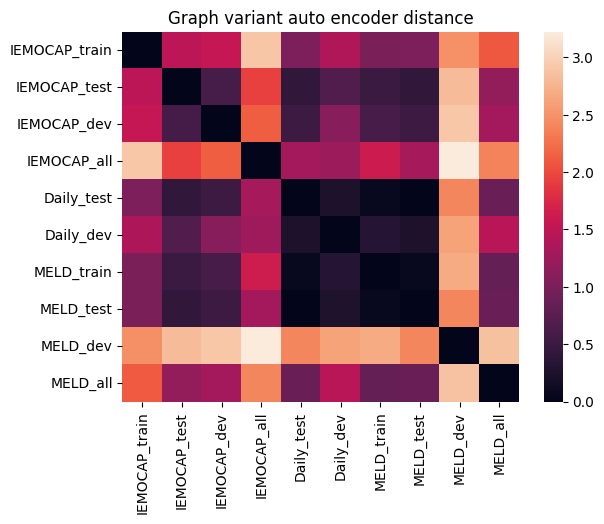

In [93]:
ax = plt.axes()
sns.heatmap(distance, annot=False, ax=ax)
ax.set_title('Graph variant auto encoder distance')
plt.show()

In [94]:
rawIM = pd.read_pickle("data/IEMOCAP_raw.pkl")

In [97]:
rawMELD = pd.read_pickle("data/MELD_raw.pkl")

In [119]:
rawDD = pd.read_pickle("data/Daily_Dailog_raw.pkl")

In [99]:
rawMELD['dev']['conversation']

[['Oh my God, he\x92s lost it. He\x92s totally lost it.', 'What?'],
 ['Or! Or, we could go to the bank, close our accounts and cut them off at the source.',
  'You\x92re a genius!',
  'Aww, man, now we won\x92t be bank buddies!',
  'Now, there\x92s two reasons.',
  'Hey.',
  'Hey!',
  'Ohh, you guys, remember that cute client I told you about? I bit him.',
  'Where?!',
  'On the touchy.',
  'And',
  'No, I know!',
  'I-I\x92m sorry, but the moment I touch him, I just wanna throw out my old oath and take a new, dirty one.',
  'Well, next time your massaging him, you should try and distract yourself.',
  'Yeah! Yeah! Yeah! Like-like when I\x92m doing something exciting and I don\x92t wanna get',
  'Thank you, Joey.',
  'No-no, thank you.'],
 ['Hey Estelle, listen',
  'Well! Well! Well! Joey Tribbiani! So you came back huh? They',
  'What are you talkin\x92 about? I never left you! You\x92ve always been my agent!',
  'Really?!',
  'Yeah!',
  'Oh well, no harm, no foul.'],
 ['Okay, you guy

In [102]:
rawIM['test']['conversation'][3]

['Why does that bother you?',
 "She's been in New York three and a half years.  Why all of the sudden?",
 'Well maybe.  Maybe she just wanted to see her again.',
 "What did you mean? He lived next door to the girl all of his life, why wouldn't he want to see her again? Don't look at me like that, he didn't tell me any more than he told you.",
 'How do you know he is even thinking about it?',
 'Well, so what.',
 "What's going on here, Joe?",
 'Now, listen, Kate, just-',
 "She's not his girl.  She knows she's not.",
 "She's . . . Then why is she still single.  New York is full of men, why isn't she married?  Probably a hundred people told her she's foolish, but she's waited.",
 "How do you know why she's waited?",
 "Because she knows what I know - she's faithful as a rock and my worst moments I think of her waiting and I know again that I'm right.",
 "Look.  It's a nice day.  Why are we arguing?",
 'Nobody in her- this house dares shake her faith.  Strangers might, but not his father, an

In [114]:
rawMELD['dev']['conversation'][11]

['I guess so.',
 'Here you go. Thank you!',
 "Wait, Rach! Where's the other one?",
 'Oh what, you-you want both of them?',
 "Rachel Karen Green, where's the other earring?!",
 "Okay, okay, okay, look, just don't freak out, but I kinda lost it.",
 "I know it's in the apartment, but I",
 'Well, what am I going to tell Monica? She wants to wear them tonight!',
 'Tell her to wear her own earrings.',
 'These',
 "Nooo! Nooooo! You lent me Monica's earrings?! I'm not allowed to borrow her stuff!",
 'Why not?',
 'Because I lose her stuff!']

In [112]:
rawMELD['train']['conversation'][9]

["What've you been up to?",
 'Oh, you know, the usual, teaching aerobics, partying way too much.',
 'Oh, and in case you were wondering, those are my legs on the new James Bond poster.',
 'Can you hold on a moment? I have another call.  I love her.',
 'I know.',
 "I'm back.",
 'So, are we gonna get together or what?',
 "Um, absolutely. Uh, how 'bout tomorrow afternoon? Do you know uh, Central Perk in the Village, say, five-ish?",
 "Great, I'll see you then.",
 'Ok.  Ok. Having a phone has finally paid off.',
 'Even though you do do a good Bob impression, I\'m thinkin\' when she sees you tomorow, she\'s probably gonna realize, "Hey, you\'re not Bob."',
 "I'm hoping that when Bob doesn't show up, she will seek comfort in the open arms of the wry stranger at the next table.",
 'Oh my god. You are pure evil.',
 "Ok, pure evil , horny and alone . I've done this"]

In [118]:
rawMELD['dev']['Speaker_raw'][11]

['Phoebe',
 'Rachel',
 'Phoebe',
 'Rachel',
 'Phoebe',
 'Rachel',
 'Rachel',
 'Phoebe',
 'Rachel',
 'Phoebe',
 'Rachel',
 'Phoebe',
 'Rachel']

In [120]:
rawDD['test']['conversation']

[['Hey man , you wanna buy some weed ?',
  'Some what ?',
  'Weed ! You know ? Pot , Ganja , Mary Jane some chronic !',
  'Oh , umm , no thanks .',
  'I also have blow if you prefer to do a few lines .',
  'No , I am ok , really .',
  'Come on man ! I even got dope and acid ! Try some !',
  'Do you really have all of these drugs ? Where do you get them from ?',
  'I got my connections ! Just tell me what you want and I ’ ll even give you one ounce for free .',
  'Sounds good ! Let ’ s see , I want .',
  'Yeah ?',
  'I want you to put your hands behind your head ! You are under arrest !'],
 ['The taxi drivers are on strike again .',
  'What for ?',
  'They want the government to reduce the price of the gasoline .',
  'It is really a hot potato .'],
 ["We've managed to reduce our energy consumption in our factory by about 15 per cent in the last two years .",
  "That's excellent . How have you managed that ?",
  "Mainly because we've invested in a heat recovery system .",
  'What does th

In [122]:
DD_topic = pd.read_pickle("data/Daily_topic_raw_fix_topic.pkl")

In [123]:
DD_topic.keys()

dict_keys(['conversation', 'emotions', 'actions', 'topics', 'speakers'])

In [132]:
DD_topic["topics"].index(10)

12541

In [133]:
DD_topic['conversation'][12541]

['Hello , welcome to IBA . What can I do for you ?',
 'Do you offer a safety deposit box rental service here ?',
 'We certainly do . May I ask you the purpose of the rental ?',
 "I'd like to put some valuables inside , you know , documents and jewellery , things like that .",
 'I see . We have various rental periods . How long would you like to rent it for ?',
 'What rental do you offer ?',
 'You can choose a short-term or yearly rental .',
 "I'll have to ask my wife how long she'll need it for as it is mainly for her belongings . I'll come back after we have discussed it . Thanks for your help ."]

In [ ]:
'Hello , I have a reservation for a double .',
 "What's your last name ?",
 "It's Smith . Here is my driver's license .",
 'Yes , I do show your reservation . How could you like to pay for the room ?',
 "I'd like to put it on my VISA .",
 'Fine . Here is your room key , here is also a map of our hotel . The swimming pool , gym and sauna are all located on first floor .',
 'Great , is our room ready yet ?',
 'Yes . If you want to order room service , just press 0 on your phone , and that will connect you with the front desk .

In [ ]:
"Stop running around in front of the TV , will you ? Why don't you just sit and watch ?",
 "I've tried , but I can't stand the bald man talking so loudly in the program .",
 'Then stay away . No one is keeping you from doing that .',
 "Don't be so irritable . I just don't understand the program , that's all .",
 'All right , I will explain it to you later on . Now scram .',
 "Ok . I will wait until you have had your fun , if that's what you want .",
 "That's exactly what I want , thank you ."